# Importações

In [13]:
# Framework Pytorch

import torch
import torch.nn as nn

# Otimizador (Adam)
import torch.optim as optim

# Carregar os dados como batches
from torch.utils.data  import DataLoader, TensorDataset

# manipulação de dados
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

# separa entre test e treino
from sklearn.model_selection import train_test_split

# Normaliza os dados
from  sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Gráfico
import matplotlib.pyplot as plt

# Métricas
from sklearn.metrics import classification_report, confusion_matrix

## Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

Usando device: cuda


# Carregar o CSV e entender os dados

In [3]:
# Carrega o CSV
df = pd.read_csv("heart.csv")

# Verifica as dimensões e colunas
print(df.shape)
print(df.columns.tolist())

(918, 12)
['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


In [4]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [5]:
# Verifica se há valores nulos

df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


# Pré-processamento dos dados

In [8]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [9]:
# Dados com categoricos para númericos
df["Sex"] = df["Sex"].map({"M":1, "F":0})
df["ExerciseAngina"] = df["ExerciseAngina"].map({"Y": 1, "N": 0})

df = pd.get_dummies(df, columns=["ChestPainType", "RestingECG", "ST_Slope"], drop_first=True, dtype=int)

# Separar variáveis e rótulos
X = df.drop('HeartDisease', axis=1).values

y = df["HeartDisease"]

# Padronização
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Converter para tensores
X_treino = torch.tensor(X_treino, dtype=torch.float32)
X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32).unsqueeze(1)
y_teste = torch.tensor(y_teste.values, dtype=torch.float32).unsqueeze(1)


# Criar DataLoaders
batch_size = 32
loader_treino = DataLoader(TensorDataset(X_treino, y_treino), batch_size=batch_size, shuffle=True)
loader_teste = DataLoader(TensorDataset(X_teste,  y_teste), batch_size=batch_size)

# Criando a Rede Neural

In [10]:
class RedeCardio(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return(x)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RedeCardio(input_dim=X.shape[1]).to(device)

# Treinamento da rede

In [12]:
import torch.optim as optim

# Função de perda (como é binário, usamos Binary Cross Entropy)
criterion = nn.BCELoss()

# Otimizador (usando Adam, que é ótimo para redes neurais)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Número de épocas
num_epochs = 50

for epoca in range(num_epochs):
  model.train()
  perda_total = 0
  corretos = 0
  total = 0

  for X_batch, y_batch in loader_treino:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()            # zera os gradientes antigos
        saida = model(X_batch)           # passa o batch pela rede
        loss = criterion(saida, y_batch) # calcula a perda
        loss.backward()                  # calcula os gradientes
        optimizer.step()                 # atualiza os pesos

        # Acumulando métricas
        perda_total += loss.item()
        pred = (saida > 0.5).float()     # converte probabilidade em 0 ou 1
        corretos += (pred == y_batch).sum().item()
        total += y_batch.size(0)

  acc = 100 * corretos / total
  print(f"Época {epoca+1}/{num_epochs} - Loss: {perda_total:.4f} - Acurácia: {acc:.2f}%")

Época 1/50 - Loss: 14.8463 - Acurácia: 75.75%
Época 2/50 - Loss: 11.8477 - Acurácia: 84.33%
Época 3/50 - Loss: 8.9817 - Acurácia: 86.10%
Época 4/50 - Loss: 7.9790 - Acurácia: 86.10%
Época 5/50 - Loss: 7.5959 - Acurácia: 86.92%
Época 6/50 - Loss: 7.3844 - Acurácia: 87.47%
Época 7/50 - Loss: 7.2113 - Acurácia: 87.87%
Época 8/50 - Loss: 7.0841 - Acurácia: 88.01%
Época 9/50 - Loss: 6.9398 - Acurácia: 88.28%
Época 10/50 - Loss: 6.8488 - Acurácia: 88.15%
Época 11/50 - Loss: 6.7165 - Acurácia: 88.56%
Época 12/50 - Loss: 6.6358 - Acurácia: 88.28%
Época 13/50 - Loss: 6.4929 - Acurácia: 88.56%
Época 14/50 - Loss: 6.4388 - Acurácia: 88.69%
Época 15/50 - Loss: 6.2705 - Acurácia: 88.83%
Época 16/50 - Loss: 6.2155 - Acurácia: 88.96%
Época 17/50 - Loss: 6.1135 - Acurácia: 89.24%
Época 18/50 - Loss: 6.0383 - Acurácia: 89.65%
Época 19/50 - Loss: 5.9155 - Acurácia: 90.05%
Época 20/50 - Loss: 5.8128 - Acurácia: 90.19%
Época 21/50 - Loss: 5.7694 - Acurácia: 91.14%
Época 22/50 - Loss: 5.6665 - Acurácia: 90

In [19]:
model.eval()

y_verdadeiro = []
y_predito = []

with torch.no_grad():
    for X_batch, y_batch in loader_teste:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        saida = model(X_batch)
        pred = (saida > 0.5).float()

        y_verdadeiro.extend(y_batch.cpu().numpy().flatten())
        y_predito.extend(pred.cpu().numpy().flatten())

print("📄 Classification Report:")
print(classification_report(y_verdadeiro, y_predito, digits=4))


📄 Classification Report:
              precision    recall  f1-score   support

         0.0     0.7957    0.9024    0.8457        82
         1.0     0.9121    0.8137    0.8601       102

    accuracy                         0.8533       184
   macro avg     0.8539    0.8581    0.8529       184
weighted avg     0.8602    0.8533    0.8537       184



c:\Users\yasmi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


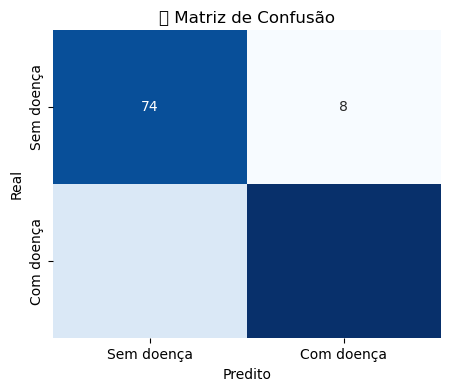

In [22]:
import seaborn as sns

# Cria a matriz
cm = confusion_matrix(y_verdadeiro, y_predito)

# Plot com Seaborn
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Sem doença", "Com doença"],
            yticklabels=["Sem doença", "Com doença"])

plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("🔍 Matriz de Confusão")
plt.show()


In [23]:
import numpy as np

# Substitua os valores abaixo com os que quiser testar
nova_amostra = {
    'Age': 50,
    'Sex': 1,  # 1 para M, 0 para F
    'RestingBP': 130,
    'Cholesterol': 250,
    'FastingBS': 0,
    'ExerciseAngina': 0,  # 1 para Y, 0 para N
    'Oldpeak': 1.0,
    'MaxHR': 140,

    # One-hot das categorias
    'ChestPainType_ASY': 0,
    'ChestPainType_NAP': 1,
    'ChestPainType_TA': 0,

    'RestingECG_LVH': 0,
    'RestingECG_Normal': 1,

    'ST_Slope_Flat': 0,
    'ST_Slope_Up': 1
}


In [24]:
# Organiza os valores na ordem certa
entrada = np.array([list(nova_amostra.values())], dtype=np.float32)

# Normaliza com o mesmo scaler do treino
entrada_normalizada = scaler.transform(entrada)

# Converte em tensor e move para a GPU se disponível
entrada_tensor = torch.tensor(entrada_normalizada, dtype=torch.float32).to(device)


In [25]:
model.eval()
with torch.no_grad():
    saida = model(entrada_tensor)
    probabilidade = saida.item()
    classe = 1 if probabilidade > 0.5 else 0

print(f"🧠 Probabilidade de doença cardíaca: {probabilidade:.4f}")
print(f"🩺 Diagnóstico do modelo: {'Com doença' if classe == 1 else 'Sem doença'}")


🧠 Probabilidade de doença cardíaca: 1.0000
🩺 Diagnóstico do modelo: Com doença
